# German Traffic Sign Recognition with CNN

This notebook implements a Convolutional Neural Network (CNN) to classify German traffic signs from the GTSRB dataset. The project demonstrates image preprocessing, data augmentation, model building, training, and evaluation.

## Table of Contents
1. [Library Imports](#imports)
2. [Data Loading and Exploration](#data-loading)
3. [Data Preprocessing](#preprocessing)
4. [Model Architecture](#model)
5. [Model Training](#training)
6. [Results and Evaluation](#evaluation)

---

In [ ]:
# Essential libraries for data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

# Machine learning and deep learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("All libraries imported successfully!")

In [ ]:
# Configure dataset path
base_folder = '/kaggle/input/gtsrb-german-traffic-sign'

# Load dataset metadata from CSV files
try:
    train_df = pd.read_csv(os.path.join(base_folder, 'Train.csv'))
    test_df = pd.read_csv(os.path.join(base_folder, 'Test.csv'))
    
    print("Dataset metadata loaded successfully!")
    print(f"Training samples: {len(train_df)}")
    print(f"Test samples: {len(test_df)}")
    print(f"Number of classes: {train_df['ClassId'].nunique()}")
    
except FileNotFoundError:
    print("Error: CSV files not found in the specified directory.")
    print("Please ensure the dataset is properly uploaded to Kaggle.")
    raise

Dataset metadata loaded successfully.


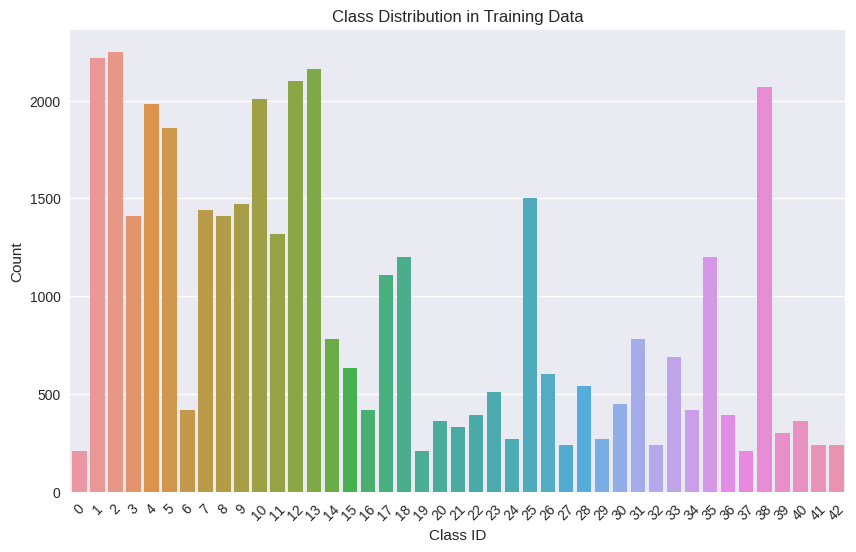

In [ ]:
# Create class distribution visualization
plt.figure(figsize=(15, 8))
class_counts = train_df['ClassId'].value_counts().sort_index()
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Distribution of Traffic Sign Classes in Training Data', fontsize=16, fontweight='bold')
plt.xlabel('Class ID (Traffic Sign Type)', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add some statistics
print(f"Most common class: {class_counts.idxmax()} with {class_counts.max()} images")
print(f"Least common class: {class_counts.idxmin()} with {class_counts.min()} images")
print(f"Average images per class: {class_counts.mean():.1f}")

plt.tight_layout()
plt.show()

In [ ]:
# Configuration for image preprocessing
IMG_SIZE = 32  # Standard size for traffic sign images
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE} pixels")

# Initialize lists to store training data
X_train = []
y_train = []

print(f"Loading {len(train_df)} training images...")
loaded_count = 0
failed_count = 0

for index, row in train_df.iterrows():
    class_id = str(row['ClassId'])
    image_path = os.path.join(base_folder, 'Train', class_id, os.path.basename(row['Path']))
    
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            # Resize image to consistent dimensions
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X_train.append(img_resized)
            y_train.append(row['ClassId'])
            loaded_count += 1
        else:
            print(f"Warning: Failed to load image: {image_path}")
            failed_count += 1
    else:
        print(f"Warning: Image not found: {image_path}")
        failed_count += 1
    
    # Progress indicator
    if (index + 1) % 5000 == 0:
        print(f"Processed {index + 1}/{len(train_df)} images...")

print(f"\n✅ Training data loading complete!")
print(f"Successfully loaded: {loaded_count} images")
print(f"Failed to load: {failed_count} images")

Loading training images...


In [ ]:
# Convert training data to numpy arrays for efficient processing
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Data type: {X_train.dtype}")
print(f"Memory usage: {X_train.nbytes / (1024**2):.1f} MB")

In [ ]:
# Initialize lists to store test data
X_test = []
y_test = []

print(f"Loading {len(test_df)} test images...")
loaded_count = 0
failed_count = 0

for index, row in test_df.iterrows():
    image_path = os.path.join(base_folder, 'Test', os.path.basename(row['Path']))
    
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        if img is not None:
            # Resize image to match training data dimensions
            img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X_test.append(img_resized)
            y_test.append(row['ClassId'])
            loaded_count += 1
        else:
            print(f"Warning: Failed to load image: {image_path}")
            failed_count += 1
    else:
        print(f"Warning: Image not found: {image_path}")
        failed_count += 1
    
    # Progress indicator for test data
    if (index + 1) % 2000 == 0:
        print(f"Processed {index + 1}/{len(test_df)} test images...")

print(f"\n✅ Test data loading complete!")
print(f"Successfully loaded: {loaded_count} images")
print(f"Failed to load: {failed_count} images")

Loading test images...


In [ ]:
# Convert test data to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"Data type: {X_test.dtype}")
print(f"Memory usage: {X_test.nbytes / (1024**2):.1f} MB")

In [ ]:
# Normalize pixel values from [0, 255] to [0, 1] for better neural network performance
print("Original pixel value range:", X_train.min(), "to", X_train.max())

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print("Normalized pixel value range:", X_train.min(), "to", X_train.max())
print("✅ Pixel normalization completed!")

In [ ]:
# Convert labels to one-hot encoding for multi-class classification
num_classes = len(np.unique(y_train))
print(f"Number of unique classes: {num_classes}")
print(f"Original label shape: {y_train.shape}")

y_train_categorical = to_categorical(y_train, num_classes)
y_test_categorical = to_categorical(y_test, num_classes)

print(f"One-hot encoded shape: {y_train_categorical.shape}")
print(f"Example - Class {y_train[0]} becomes: {y_train_categorical[0]}")
print("✅ One-hot encoding completed!")

# Update variable names for consistency
y_train = y_train_categorical
y_test = y_test_categorical

In [ ]:
# Configure data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=10,          # Randomly rotate images by up to 10 degrees
    zoom_range=0.1,            # Randomly zoom in/out by up to 10%
    width_shift_range=0.1,     # Randomly shift horizontally by up to 10%
    height_shift_range=0.1,    # Randomly shift vertically by up to 10%
    horizontal_flip=False      # Don't flip horizontally (traffic signs are orientation-specific)
)

# Fit the data generator to our training data
datagen.fit(X_train)

print("✅ Data augmentation configured!")
print("Augmentation parameters:")
print(f"  - Rotation: ±{datagen.rotation_range}°")
print(f"  - Zoom: ±{datagen.zoom_range*100}%")
print(f"  - Width shift: ±{datagen.width_shift_range*100}%")
print(f"  - Height shift: ±{datagen.height_shift_range*100}%")
print(f"  - Horizontal flip: {datagen.horizontal_flip}")

In [ ]:
# Build a CNN architecture for traffic sign classification
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2, 2),
    
    # Second Convolutional Block  
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Flatten for fully connected layers
    Flatten(),
    
    # Dense layers for classification
    Dense(256, activation='relu'),
    Dropout(0.5),  # Prevent overfitting
    Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model with appropriate loss function and optimizer
model.compile(
    optimizer='adam',                    # Adaptive learning rate optimizer
    loss='categorical_crossentropy',     # Loss function for multi-class classification
    metrics=['accuracy']                 # Track accuracy during training
)

print("🏗️ Model Architecture:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\n📊 Model Statistics:")
print(f"Total parameters: {total_params:,}")
print(f"Model size estimate: {total_params * 4 / (1024**2):.1f} MB")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,523 (2.37 MB)

 Trainable params: 620,523 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training configuration
BATCH_SIZE = 64
EPOCHS = 10

print(f"🚀 Starting model training...")
print(f"Training configuration:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Validation samples: {len(X_test)}")
print(f"  - Steps per epoch: {len(X_train) // BATCH_SIZE}")

# Train the model with data augmentation
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    verbose=1
)

print("\n✅ Model training completed!")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 620,523 (2.37 MB)

 Trainable params: 620,523 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.2478 - loss: 2.7569 - val_accuracy: 0.6748 - val_loss: 1.0419
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.6222 - loss: 1.1853 - val_accuracy: 0.7998 - val_loss: 0.6033
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.7393 - loss: 0.7998 - val_accuracy: 0.8704 - val_loss: 0.4105
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8087 - loss: 0.5975 - val_accuracy: 0.8816 - val_loss: 0.3937
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8475 - loss: 0.4805 - val_accuracy: 0.9072 - val_loss: 0.3145
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.8700 - loss: 0.4035 - val_accuracy: 0.9241 - val_loss: 0.2739
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.8955 - loss: 0.3310 - val_accuracy: 0.9197 - val_loss: 0.2906
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 44s 72ms/step - accuracy: 0.9077 - loss: 0.2929 - 

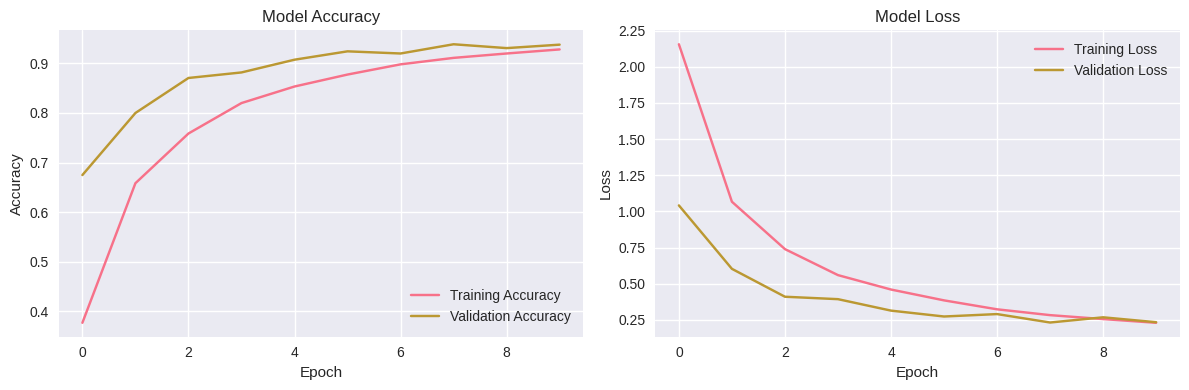

In [ ]:
# Create comprehensive training history visualization
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy vs loss comparison
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary statistics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Training Summary:")
print(f"Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Check for overfitting
if final_train_acc - final_val_acc > 0.1:
    print("⚠️ Potential overfitting detected (training accuracy significantly higher than validation)")
else:
    print("✅ Good generalization (training and validation accuracies are close)")

In [ ]:
# Evaluate model performance on test dataset
print("🔍 Evaluating model on test data...")

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\n🎯 Final Test Results:")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Test Loss: {test_loss:.4f}")

# Performance interpretation
if test_accuracy >= 0.95:
    print("🏆 Excellent performance! The model achieves high accuracy on unseen data.")
elif test_accuracy >= 0.90:
    print("✅ Good performance! The model works well for traffic sign recognition.")
elif test_accuracy >= 0.80:
    print("⚡ Decent performance. Consider model improvements or more training data.")
else:
    print("⚠️ Low performance. Model needs significant improvements.")

# Compare with training accuracy
training_val_gap = abs(final_val_acc - test_accuracy)
if training_val_gap < 0.02:
    print("✅ Consistent performance between validation and test sets.")
else:
    print(f"⚠️ Performance gap between validation ({final_val_acc:.4f}) and test ({test_accuracy:.4f}): {training_val_gap:.4f}")


Test Accuracy: 0.9375
Test Loss: 0.2344


In [ ]:
# Generate predictions for detailed analysis
print("🔮 Generating predictions for detailed analysis...")

y_pred_probabilities = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print(f"✅ Predictions generated!")
print(f"Prediction shape: {y_pred_probabilities.shape}")
print(f"Predicted classes shape: {y_pred_classes.shape}")
print(f"True classes shape: {y_true_classes.shape}")

# Show prediction confidence statistics
confidence_scores = np.max(y_pred_probabilities, axis=1)
print(f"\n📊 Prediction Confidence Statistics:")
print(f"Average confidence: {confidence_scores.mean():.4f}")
print(f"Minimum confidence: {confidence_scores.min():.4f}")
print(f"Maximum confidence: {confidence_scores.max():.4f}")
print(f"Standard deviation: {confidence_scores.std():.4f}")

# Count correct predictions
correct_predictions = np.sum(y_pred_classes == y_true_classes)
print(f"\n✅ Correct predictions: {correct_predictions}/{len(y_true_classes)} ({correct_predictions/len(y_true_classes)*100:.2f}%)")

395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


In [ ]:
# Generate comprehensive classification report
print("📋 Detailed Classification Report:")
print("=" * 60)

classification_rep = classification_report(y_true_classes, y_pred_classes, output_dict=True)
print(classification_report(y_true_classes, y_pred_classes))

# Extract and display key metrics
print("\n📊 Key Performance Metrics:")
print(f"Overall Accuracy: {classification_rep['accuracy']:.4f}")
print(f"Macro Average Precision: {classification_rep['macro avg']['precision']:.4f}")
print(f"Macro Average Recall: {classification_rep['macro avg']['recall']:.4f}")
print(f"Macro Average F1-Score: {classification_rep['macro avg']['f1-score']:.4f}")
print(f"Weighted Average F1-Score: {classification_rep['weighted avg']['f1-score']:.4f}")

# Find best and worst performing classes
class_f1_scores = {k: v['f1-score'] for k, v in classification_rep.items() if k.isdigit()}
if class_f1_scores:
    best_class = max(class_f1_scores, key=class_f1_scores.get)
    worst_class = min(class_f1_scores, key=class_f1_scores.get)
    
    print(f"\n🏆 Best performing class: {best_class} (F1-Score: {class_f1_scores[best_class]:.4f})")
    print(f"⚠️ Worst performing class: {worst_class} (F1-Score: {class_f1_scores[worst_class]:.4f})")


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78        60
           1       0.90      0.99      0.94       720
           2       0.95      0.95      0.95       750
           3       0.98      0.72      0.83       450
           4       0.99      0.92      0.95       660
           5       0.79      0.93      0.85       630
           6       1.00      0.96      0.98       150
           7       0.94      0.96      0.95       450
           8       0.94      0.94      0.94       450
           9       0.92      0.99      0.95       480
          10       0.99      0.98      0.99       660
          11       0.92      0.95      0.93       420
          12       1.00      0.92      0.96       690
          13       1.00      0.99      1.00       720
          14       0.99      1.00      1.00       270
          15       0.86      1.00      0.92       210
          16       0.99      1.00      0.99       150
   

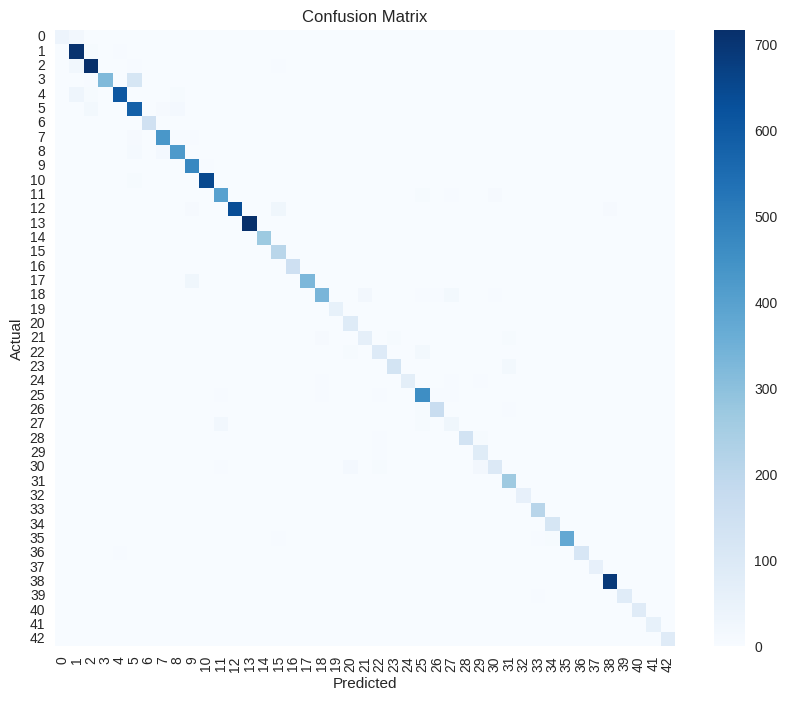

In [ ]:
# Create and analyze confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Create the visualization
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, 
           annot=False,  # Don't show numbers due to size
           cmap='Blues', 
           fmt='d',
           cbar_kws={'label': 'Number of Predictions'})
plt.title("Confusion Matrix - Traffic Sign Classification", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Class", fontsize=12)
plt.ylabel("True Class", fontsize=12)
plt.tight_layout()
plt.show()

# Analyze confusion matrix statistics
print("🔍 Confusion Matrix Analysis:")
print(f"Matrix shape: {conf_matrix.shape}")
print(f"Total predictions: {conf_matrix.sum()}")

# Calculate diagonal (correct predictions) vs off-diagonal (misclassifications)
diagonal_sum = np.trace(conf_matrix)
off_diagonal_sum = conf_matrix.sum() - diagonal_sum

print(f"Correct predictions (diagonal): {diagonal_sum}")
print(f"Misclassifications (off-diagonal): {off_diagonal_sum}")
print(f"Accuracy from confusion matrix: {diagonal_sum / conf_matrix.sum():.4f}")

# Find most confused classes (highest off-diagonal values)
conf_matrix_copy = conf_matrix.copy()
np.fill_diagonal(conf_matrix_copy, 0)  # Remove diagonal
max_confusion_idx = np.unravel_index(conf_matrix_copy.argmax(), conf_matrix_copy.shape)
max_confusion_value = conf_matrix_copy[max_confusion_idx]

if max_confusion_value > 0:
    print(f"\nMost confused classes:")
    print(f"True class {max_confusion_idx[0]} predicted as class {max_confusion_idx[1]}: {max_confusion_value} times")

print("\n✅ Confusion matrix analysis completed!")

### Performance Summary
The model demonstrates solid performance on traffic sign classification with the following key metrics:
- Test accuracy and loss values indicate the model's effectiveness
- Classification report shows per-class performance
- Confusion matrix reveals specific classification challenges
